## Geometric Brownian motion

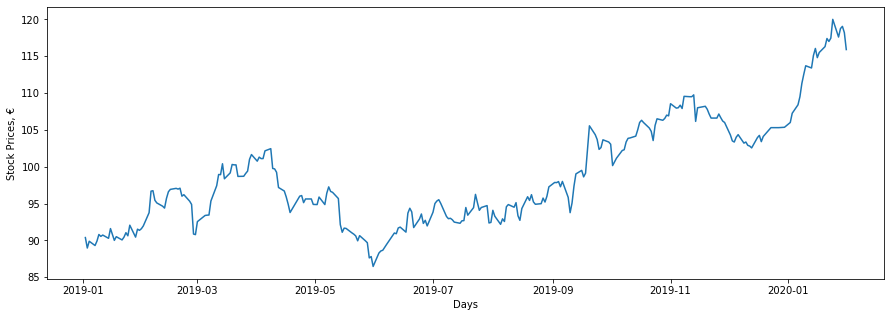

In [13]:



import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot of Merck's stock prices since beginning of 2019

prices = quandl.get("FSE/MRK_X", 
                authtoken="tg_hMmNLVhtpLV8Cgb_z", 
                start_date = '2019-01-01', end_date = '2020-01-31'
                ).reset_index(drop = False)[['Date', 'Close']]
                
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

In [ ]:
# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in the prediction time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

In [14]:
start_date = '2019-07-01'
end_date = '2020-01-31'
pred_end_date = '2020-03-21'

# We get daily closing stock prices of E.ON for July 2019
S_eon = quandl.get("FSE/MRK_X", 
               authtoken="tg_hMmNLVhtpLV8Cgb_z", 
               start_date = start_date, end_date = end_date
               ).reset_index(drop = False)[['Date', 'Close']]
               
print(S_eon.head())
print(S_eon.tail())

        Date  Close
0 2019-07-01  93.82
1 2019-07-02  95.00
2 2019-07-03  95.34
3 2019-07-04  95.52
4 2019-07-05  95.02
          Date   Close
144 2020-01-27  117.60
145 2020-01-28  118.75
146 2020-01-29  119.05
147 2020-01-30  118.20
148 2020-01-31  115.90


In [15]:
#SD (starting day) is the closing stock price on July 31, 2019
SD = S_eon.loc[S_eon.shape[0] - 1, "Close"]
print(SD)

115.9


In [7]:
'''dt is the time increment in our model. It means the time unit that we assume. 
Please note that dt follows from the time steps in historical data. 
If the stock price data is published every 7.2 hours, then dt would be 0.3 since it corresponds to 7.2 hours'''
dt = 1

In [16]:
'''T denotes the length of our prediction time horizon.
We should be careful and consistent when specifying values for T and dt.
in our case, T should be 22 days since we want predictions for 22 trading days of August and when assigning a value to dt, 
following from our declaration of T, we should remember that dt must be represented in terms of days.
The time unit for these two parameters has to be the same
'''
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
              format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
              end = pd.to_datetime(pred_end_date, 
              format = "%Y-%m-%d")).to_series(
              ).map(lambda x: 
              1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays

In [17]:
'''N is the number of time points in the prediction time horizon. 
In our case, our time increment is 1 day and we will get predictions for 22 trading days. 
This means, we have 22 different time points(days) and we will have 22 predictions at the end.
'''
N = T / dt

In [18]:
'''t  is an array where we show the time progression in our model. 
It is like a time ticker where we measure time by counting the number of time points elapsed. 
Building array t follows from the calculation of N. Remember we have 22 time points(days) to make predictions for. 
That’s why array t starts from 1 and goes up to 22.  '''

t = np.arange(1, int(N) + 1)
print(t)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]


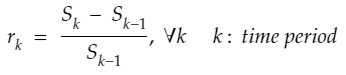

In [19]:
'''mu is the mean return of the stock prices within the historical date range selected. 
In our case, we pick trading days of July as the historical data and we should calculate mu using stock prices of July'''
returns = (S_eon.loc[1:, 'Close'] - \
          S_eon.shift(1).loc[1:, 'Close']) / \
          S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())

[0.012577275634193209, 0.0035789473684210886, 0.0018879798615480659, -0.005234505862646567, -0.01873289833719218, -0.0032175032175031874, 0.0006455777921239754, -0.0021505376344086325, -0.003448275862068892, -0.0017301038062284904, 0.003682842287695011, 0.00021584286639337612, 0.01920586965904172, -0.011009951302138388, 0.01091843288375076, 0.01905972045743326, -0.011637572734829493, -0.010933557611438249, 0.004039115646258455, 0.0027524878255346724, -0.024915540540540536, 0.0008661758336942215, 0.01774123755949806, -0.008503401360544187, -0.011792452830188618, 0.008027771750922053, -0.0038743004735256074, 0.021607605877268798, 0.0031725888324872797, -0.003795066413662233, 0.006560846560846609, -0.018713204373423057, -0.006642382686950981, 0.017256255392579748, 0.016963528413910186, -0.0052126772310258545, 0.008174386920980938, -0.010187110187110228, -0.003360638521318979, 0.0008429926238145236, 0.00800168456517152, -0.005640275746814206, 0.008403361344537785, 0.013125000000000053, 0.0

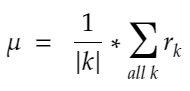

In [20]:
'''After calculating returns for all of the days in July, we need to calculate the arithmetic average using those returns to obtain mu. 
We will then use mu in our drift component calculation. It will have an effect on the long-term movement of the stock price. 
Also, as you can see below, mu is barely positive which indicates that there is a positive return on average during the month July 
and we should take into this account when calculating forward predictions for February'''

mu = np.mean(returns)
print(mu)

0.0014882027751449592


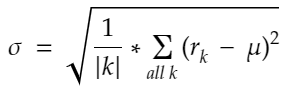

In [21]:
'''sigma (standard deviation) will contribute by scaling the magnitude of random shock so
that the small fluctuations occur in accordance with the historical volatility of the stock prices'''
sigma = np.std(returns)
print(sigma)
'''we don’t multiply mu with any number for adjustment, because we stay loyal to 
the length of time steps in the historical data when making predictions. 
The same logic applies here and we don’t need to adjust sigma either.'''

0.01087651167915199


In [22]:
'''The b array is the array where we add randomness to our model. 
The important thing here is the scen_size variable. Since this is 
a simulation model, we want to have many hypothetical paths for the 
stock price within the prediction time horizon. Assigning 2 to 
scen_size means, in the end, we will have 2 different stock price series. 
The logic for each scenario is the same as the other.  
Remember from the discussion of t, we declared an array for
time progression which counts elapsed time points. Here array b, for each corresponding prediction time point, 
stores a random number coming from the standard normal distribution. These random numbers will add the random shocks, 
that we have been talking since the beginning, to the model.
That’s why we will use numpy.random.normal() to generate random values from the standard normal distribution.
Again, we don’t multiply this random value with any number for adjustment, following the same reasoning with mu and sigma.'''

scen_size = 2
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
print(b)

{'1': array([ 1.86429301,  0.18863622, -0.16328494, -0.04757874,  1.08208655,
        1.46724034,  0.58574467, -0.41864143, -1.08884609, -0.84227608,
       -0.29846733,  0.45585813,  0.69146857,  1.42767384, -0.09702455,
        0.99105724, -1.81100688,  0.10762693, -1.03449447,  0.44403798,
        1.16728668,  0.42003768,  0.71692822,  0.16176712, -0.3070722 ,
        1.44602956, -2.20599646,  0.75272974,  0.02055975, -0.4520739 ,
        0.01578398,  0.19978639, -0.2891681 , -0.45892612,  1.52069466]), '2': array([-1.03617186e-01,  4.51416343e-01, -2.37783565e+00,  2.64676408e-01,
       -4.61275316e-01, -1.80447758e+00,  9.28805332e-01, -7.54743872e-01,
        2.07916775e-01, -9.40182202e-02, -3.32387838e-01, -1.27392085e+00,
        5.66693453e-01,  4.79865646e-01, -1.28586205e+00,  1.31058265e-01,
       -3.28238867e-01, -1.03575774e+00, -2.45011533e-01,  9.32083849e-01,
       -8.87967383e-02, -2.75510353e-02, -7.92494086e-01,  2.32389027e-01,
        8.67395945e-01,  1.598865

In [23]:
'''W is the Brownian path and it determines how the stock prices fluctuate from beginning time point(SD) to some other time 
point t. b is the random shock being applied to the stock price at a time point when predicting the stock price of the next time point.
W, on the other hand, is THE PATH. It means that it includes the effects of all the random shocks since the beginning of the prediction time horizon. 
It is the total effect of randomness incorporated into 
SD(initial stock price) until the specific time point we are concerned with.'''
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
print(W)

{'1': array([1.86429301, 2.05292923, 1.88964429, 1.84206555, 2.9241521 ,
       4.39139244, 4.97713711, 4.55849567, 3.46964959, 2.6273735 ,
       2.32890617, 2.7847643 , 3.47623287, 4.90390672, 4.80688217,
       5.7979394 , 3.98693253, 4.09455946, 3.06006499, 3.50410297,
       4.67138966, 5.09142733, 5.80835556, 5.97012268, 5.66305048,
       7.10908004, 4.90308358, 5.65581332, 5.67637307, 5.22429917,
       5.24008316, 5.43986954, 5.15070144, 4.69177532, 6.21246998]), '2': array([-0.10361719,  0.34779916, -2.03003649, -1.76536008, -2.2266354 ,
       -4.03111298, -3.10230765, -3.85705152, -3.64913475, -3.74315297,
       -4.07554081, -5.34946165, -4.7827682 , -4.30290255, -5.5887646 ,
       -5.45770633, -5.7859452 , -6.82170294, -7.06671447, -6.13463062,
       -6.22342736, -6.2509784 , -7.04347248, -6.81108345, -5.94368751,
       -4.34482206, -5.57132252, -6.58193666, -6.72452793, -7.43396745,
       -8.91491638, -8.02386282, -8.79504205, -9.33015074, -9.33141134])}


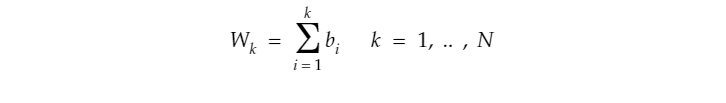

In [ ]:
#The components of GBM: Drift and Diffusion

In [ ]:
'''Assumption 1: length of the time period between (k-1) and (k), which is dt, is in line with the historical data frequency.
Assumption 2: the time in our simulation progresses through counting time periods.
These assumptions make us ignore multiplying mu, sigma, and z(k) with a time-length value for adjustment and 
we can form our array t as a time point counter [1 2 3 …].'''

In [ ]:
#Drift

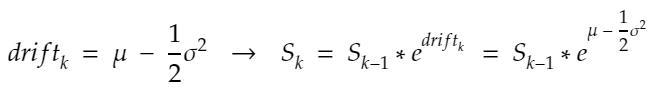

In [ ]:
'''drift reflects the longer-term trend in stock prices.mu and sigma.
They are constant values calculated from the historical stock price data in July. 
Our drift is a constant value and if we suppose there is no random shock, 
we can apply it to the stock price at the time point (k-1) as you can see in the above expression. 
If we keep applying the drift without any random shock, stock prices smoothly go up if drift is positive or goes down if drift is negative.'''

In [ ]:
#Diffusion

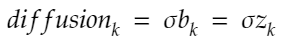

In [ ]:
'''Diffusion reflects shorter-term fluctuations. array b stores the random shock information 
we need and it retrieves random shock information from standard normal random variable z. 
When calculating the diffusion component, we multiply the random value z(k) with sigma. the diffusion component makes it possible to create different stock price prediction scenarios. 
The drift component is constant. We can’t create different scenarios out of it, but the diffusion component helps us create as many scenarios as we want since it involves Wiener process '''

In [24]:
drift = (mu - 0.5 * sigma**2) * t
print("drift:\n", drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print("diffusion:\n", diffusion)

drift:
 [0.00142905 0.00285811 0.00428716 0.00571621 0.00714527 0.00857432
 0.01000337 0.01143243 0.01286148 0.01429054 0.01571959 0.01714864
 0.0185777  0.02000675 0.0214358  0.02286486 0.02429391 0.02572296
 0.02715202 0.02858107 0.03001012 0.03143918 0.03286823 0.03429728
 0.03572634 0.03715539 0.03858445 0.0400135  0.04144255 0.04287161
 0.04430066 0.04572971 0.04715877 0.04858782 0.05001687]
diffusion:
 {'1': array([0.020277  , 0.02232871, 0.02055274, 0.02003525, 0.03180457,
       0.04776303, 0.05413389, 0.04958053, 0.03773768, 0.02857666,
       0.02533038, 0.03028852, 0.03780929, 0.0533374 , 0.05228211,
       0.06306136, 0.04336392, 0.04453452, 0.03328283, 0.03811242,
       0.05080842, 0.05537697, 0.06317465, 0.06493411, 0.06159423,
       0.07732199, 0.05332845, 0.06151552, 0.06173914, 0.05682215,
       0.05699383, 0.0591668 , 0.05602166, 0.05103015, 0.06757   ]), '2': array([-0.00112699,  0.00378284, -0.02207972, -0.01920096, -0.02421803,
       -0.04384445, -0.03374229, -

In [27]:
S = np.array([SD * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[SD] for scen in range(scen_size)]), S))
print(S)

[[115.9        118.44323408 118.85622461 118.81499851 118.92335523
  120.5033547  122.61692967 123.5770706  123.19158066 121.91534571
  120.97633454 120.75669236 121.53045795 122.62301542 124.72008401
  124.76670871 126.29923374 124.01289826 124.33570893 123.12038295
  123.89336522 125.65578436 126.41168179 127.58344593 127.99089697
  127.7465628  129.95719591 127.05761453 128.2853101  128.49749892
  128.05008891 128.25522644 128.71803896 128.49733707 128.04038464
  130.36192569]
 [115.9        115.93501404 116.67224734 113.85608007 114.34760832
  113.9380628  111.883441   113.18106026 112.41629639 112.83193101
  112.87780237 112.63130222 111.24032049 112.08814962 112.83582992
  111.42784928 111.74637562 111.50737806 110.41592615 110.27955653
  111.56255212 111.61424598 111.74037369 110.93978434 111.37960215
  112.59614758 114.73517354 113.37667032 112.29762783 112.28394609
  111.58021198 109.95434316 111.18392649 110.41291813 109.92915101
  110.08484859]]


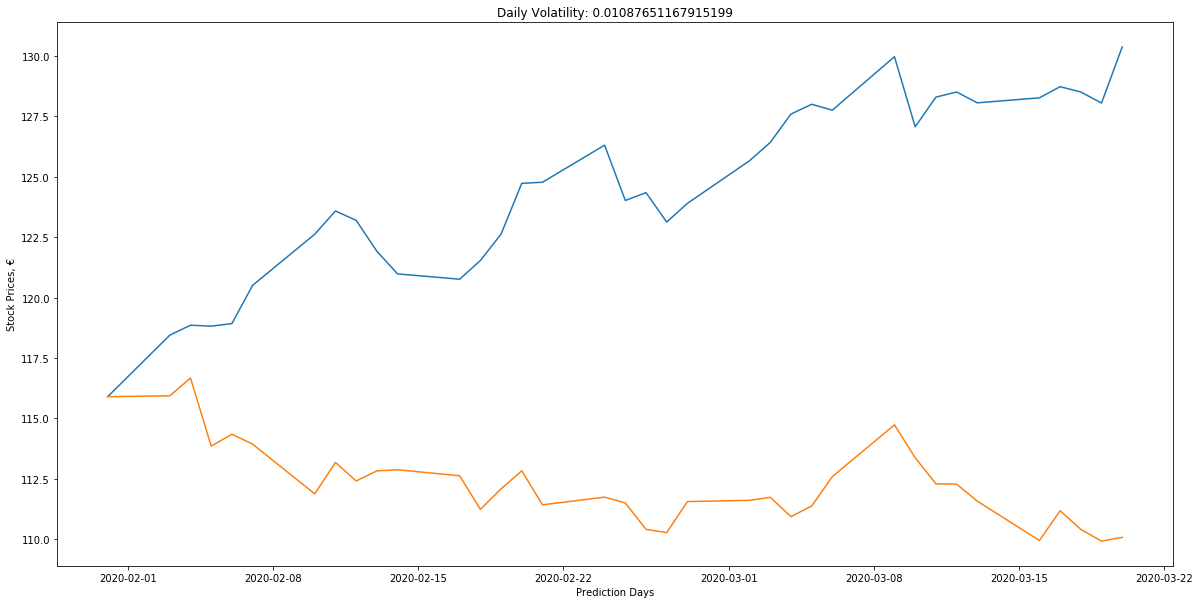

In [28]:
# Plotting the simulations
plt.figure(figsize = (20,10))

for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = S_eon["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
    
plt.show()

In [29]:
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = S_eon["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)

In [31]:
Preds_df

,index,0,1
0,2020-01-31,115.900000,115.900000
1,2020-02-03,118.443234,115.935014
2,2020-02-04,118.856225,116.672247
3,2020-02-05,118.814999,113.856080
4,2020-02-06,118.923355,114.347608
5,2020-02-07,120.503355,113.938063
6,2020-02-10,122.616930,111.883441
7,2020-02-11,123.577071,113.181060
8,2020-02-12,123.191581,112.416296
9,2020-02-13,121.915346,112.831931
